# Optimizing DTW-Based Audio-to-MIDI Alignment and Matching

This notebook provides an informal overview of the experiments presented in "Optimizing DTW-Based Audio-to-MIDI Alignment and Matching".  The goal behind this work is to automatically tune the parameters of dynamic time warping systems used for audio-to-MIDI alignment so that the system is both highly accurate and capable of reporting when an alignment was successful or not.

## Synthetic data

To automatically tune alignment systems, we first need a dataset of MIDI/audio pairs where we know what a "correct" alignment would be.  That way, we can rapidly evaluate the performance of a given system by using it to align all of the pairs and measuring the alignment error.  This allows much faster evaluation than, say, listening to alignments manually.

We create this dataset by applying a series of "corruptions" to MIDIs file which mimic the characteristics of real-world differences between MIDI files and the audio files they are a transcription of.  These include slowly warping time, cropping out sections, changing instrument numbers, dropping instruments, and changing note velocities.  The code for this step is in `corrupt_midi.py`; here's an example of corrupting a MIDI file.

In [1]:
import pretty_midi
import corrupt_midi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import create_data
import scipy.spatial
import djitw
import tabulate
import db_utils
import glob
import json
import find_best_aligners
import IPython.display
import csv

In [2]:
# Some utility functions
def compute_cqt(audio_data):
    """ Compute the log-magnitude L2 normalized CQT """
    cqt, times = create_data.extract_cqt(audio_data)
    cqt = librosa.logamplitude(cqt, ref_power=cqt.max())
    return librosa.util.normalize(cqt, 2).T, times
def display_cqt(cqt):
    """ Plot a CQT with sane defaults """
    plt.imshow(cqt.T, aspect='auto', interpolation='nearest',
               origin='lower', cmap=plt.cm.hot,
               vmin=np.percentile(cqt, 5), vmax=np.percentile(cqt, 95))
    plt.xlabel('Frame')
    plt.ylabel('Frequency bin')

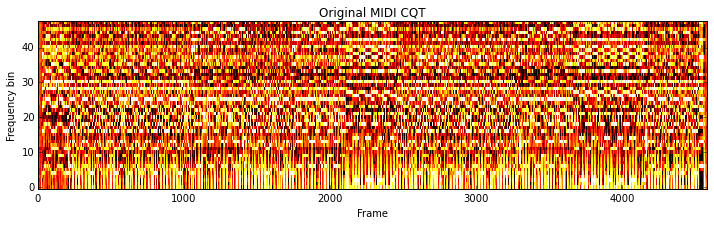

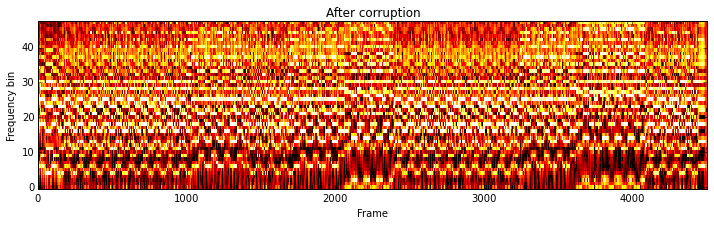

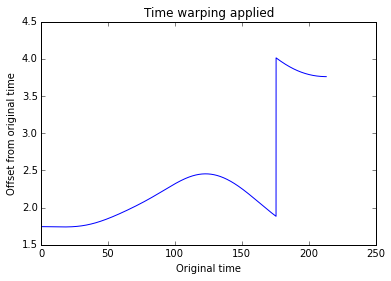

In [3]:
# Grab a MIDI file from the clean MIDIs we used in this experiment
midi_file = 'data/mid/Come as You Are.mid'
# Parse the MIDI file with pretty_midi
midi_object = pretty_midi.PrettyMIDI(midi_file)

# For illustration, we'll plot a CQT of the MIDI object
# before and after corruptions.
plt.figure(figsize=(12, 3))
original_cqt, original_times = compute_cqt(midi_object.fluidsynth(22050))
display_cqt(original_cqt)
plt.title('Original MIDI CQT')

# This is the wrapper function to apply all of the corruptions 
# defined in corrupt_midi
adjusted_times,  diagnostics = corrupt_midi.corrupt_midi(
    midi_object, original_times,
    # This defines the extent to which time will be warped
    warp_std=10,
    # These define how likely we are to crop out sections
    # We'll set them to 1 and 0 here for illustration; in the 
    # paper they are adjusted according to the desired corruption level
    start_crop_prob=0., end_crop_prob=0., middle_crop_prob=1.,
    # The likelihood that each instrument is removed
    remove_inst_prob=.3,
    # The likelihood that an instrument's program number is changed
    change_inst_prob=1.,
    # The standard deviation of velocity adjustment
    velocity_std=.2)

# Now, we can plot the CQT after corruptions.
plt.figure(figsize=(12, 3))
corrupted_cqt, corrupted_times = compute_cqt(midi_object.fluidsynth(22050))
display_cqt(corrupted_cqt)
plt.title('After corruption')

# We can also plot the timing offset, which we will try to reverse
plt.figure()
plt.plot(original_times, original_times - adjusted_times)
plt.xlabel('Original time')
plt.ylabel('Offset from original time')
plt.title('Time warping applied')

## Measuring Error

Given a synthetically corrupted MIDI file for which we know the timing distortion applied, we can measure the success of a given alignment system by computing how well it is able to reverse this distortion.  We will do this by aligning the corrupted MIDI to the original MIDI and then comparing the original alignment against the known warping curve.  A straightforward way to compare the difference between the curves is the mean absolute error in seconds.  We also threshold this error at .5, because above about .5 seconds it doesn't matter how bad the alignment is.

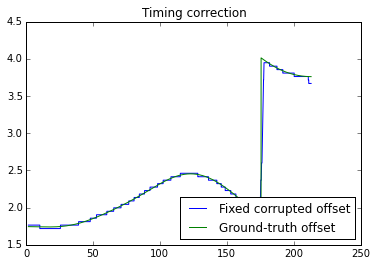

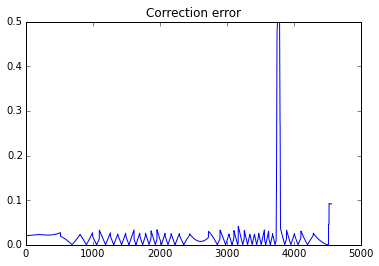

In [4]:
# Compute a pairwise distance matrix of the original and corrupted CQTs
distance_matrix = scipy.spatial.distance.cdist(
    original_cqt, corrupted_cqt, 'sqeuclidean')
# Compute the lowest-cost path via DTW
# SPOILER ALERT! These are the parameters of the "golden standard" system 
# that we propose in the paper.  See below for details.
p, q, score = djitw.dtw(
    distance_matrix, .96, np.median(distance_matrix), inplace=0)

# Plot the aligned corrupted times and ground-truth times
plt.figure()
plt.plot(original_times[p], original_times[p] - corrupted_times[q])
plt.plot(original_times[p], original_times[p] - adjusted_times[p])
plt.legend(['Fixed corrupted offset', 'Ground-truth offset'], loc='lower right')
plt.title('Timing correction')

# Compute the absolute error, clipped to within .5 seconds
plt.figure()
error = np.abs(np.clip(
    corrupted_times[q] - adjusted_times[p], -.5, .5))
plt.plot(error)
plt.title('Correction error')

## Optimizing alignment performance

Now that we have a rapid way to compute a performance metric for a given alignment system, we can rapidly test out differently-designed systems.  We created a dataset of 1,000 corrupted MIDI files using the process described above. Instead of tuning parameters by hand, we used Bayesian optimization, which models the relationship between parameters and an objective value (here, the mean alignment error across all files in the dataset) and then predicts new parameter values which should achieve a better objective value.  We optimized the representation used for MIDI and audio files, the distance metric, normalization scheme, whether to beat synchronize, the penalty scale, etc.  Below is a table of the top-performing systems.  The best-performing system achieved a mean absolute error of about 18 milliseconds, which is pretty good!  Note that an alignment system using the "cosine" metric is equivalent to a `norm = 2, metric = 'sqeuclidean'` system regardless of the norm used.

In [5]:
# Load in the results from the parameter search experiment
params, objectives = db_utils.get_experiment_results(
    'results/parameter_experiment_gp/*.json')
# Truncate to the top 20 results
good = np.argsort(objectives)[:20]
params = [params[n] for n in good]
objectives = [objectives[n] for n in good]
# Pretty-print using tabulate
for param, objective in zip(params, objectives):
    param['objective'] = objective
print tabulate.tabulate(params, headers=dict((k, k) for k in params[0]))

  band_mask    add_pen    standardize  metric       feature      beat_sync    objective     gully    norm
-----------  ---------  -------------  -----------  ---------  -----------  -----------  --------  ------
          0   1.03507               1  sqeuclidean  gram                 0    0.0180094  0.967203       2
          0   0.840218              0  cosine       gram                 0    0.018069   0.97018      inf
          0   0.944247              0  cosine       gram                 0    0.018116   0.967956
          0   0.822652              0  cosine       gram                 0    0.0181264  0.974826
          0   0.929215              0  cosine       gram                 0    0.0181429  0.971404
          0   0.920111              1  cosine       gram                 0    0.0181909  0.962121       1
          0   0.947526              0  cosine       gram                 0    0.0181951  0.973988
          0   0.89384               1  cosine       gram                 0    

## Optimizing confidence score normalization

DTW provides a distance-like metric by computing the total distance between aligned frames.  There are various ways to normalize this metric to report a reliable confidence score.  So, we performed an exhaustive search over these normalization strategies by computing the Kendall rank correlation between every normalized DTW distance variant and the alignment error for all of the systems generated by Bayesian optimization.  The rank correlation was computed over the dataset we created above, plus an additional dataset of 1,000 synthetic pairs which were most likely to fail due to a higher amount of corruption, which allows us to verify that a system can report when it fails.  The highest correlation among the best-accuracy systems was .710; below, we explore the correlation for the absolute best accuracy-system.

Kendall rank correlation: 0.692705347799


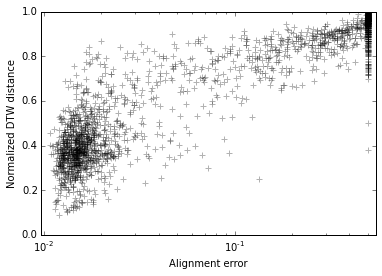

In [6]:
# Load in all confidence reporting experiment trials
trials = []
for trial_file in glob.glob('results/confidence_experiment/*.json'):
    with open(trial_file) as f:
        trials.append(json.load(f))
# Retrieve the lowest-achieved mean absolute error
best_easy_error = objectives[0]
# Retrieve the confidence reporting trial for this system
best_trial = [t for t in trials
               if np.allclose(np.mean(t['results']['easy_errors']),
                              best_easy_error)][0]
# Retrieve the results from this trial
best_result = best_trial['results']

# Plot a scatter plot of mean alignment error vs. confidence score
errors = np.array(best_result['hard_errors'] + best_result['easy_errors'])
scores = np.array(best_result['hard_penalty_len_norm_mean_norm_scores'] +
                  best_result['easy_penalty_len_norm_mean_norm_scores'])
plt.scatter(errors, scores, marker='+', c='black', alpha=.3, s=40)
plt.gca().set_xscale('log')
plt.ylim(0., 1.)
plt.xlim(.9*np.min(errors), np.max(errors)*1.1)
plt.xlabel('Alignment error')
plt.ylabel('Normalized DTW distance')

# Print the correlation achieved
print "Kendall rank correlation: {}".format(
    find_best_aligners.kendall_ignore_ties(errors, scores))

## The "golden standard"

Now, we have a large collection of DTW systems for which we know both how well they will be able to correctly aligned songs and how reliably they can report their confidence.  We have one more goal: To produce a system which is straightforward to explain and implement.  Investigating the results, we chose the following system, whose performance was not significantly different than the highest-performing system but is much more straightforward to implement:

In [7]:
# Audio/CQT parameters
FS = 22050
NOTE_START = 36
N_NOTES = 48
HOP_LENGTH = 1024
# DTW parameters
GULLY = .96


def compute_cqt(audio_data):
    """ Compute the CQT and frame times for some audio data """
    # Compute CQT
    cqt = librosa.cqt(audio_data, sr=FS, fmin=librosa.midi_to_hz(NOTE_START),
                      n_bins=N_NOTES, hop_length=HOP_LENGTH, tuning=0.)
    # Compute the time of each frame
    times = librosa.frames_to_time(
        np.arange(cqt.shape[1]), sr=FS, hop_length=HOP_LENGTH)
    # Compute log-amplitude
    cqt = librosa.logamplitude(cqt, ref_power=cqt.max())
    # Normalize and return
    return librosa.util.normalize(cqt, 2).T, times

# We'll use a real-world MIDI/audio pair
audio_file = 'data/real_world/0.mp3'
midi_file = 'data/real_world/0.mid'

# Load in the audio data
audio_data, _ = librosa.load(audio_file, sr=create_data.FS)
# Compute the log-magnitude CQT of the data
audio_cqt, audio_times = compute_cqt(audio_data)
# Load and synthesize MIDI data
midi_object = pretty_midi.PrettyMIDI(midi_file)
midi_audio = midi_object.fluidsynth(fs=create_data.FS)
# Compute log-magnitude CQT
midi_cqt, midi_times = compute_cqt(midi_audio)
# Nearly all high-performing systems used cosine distance
distance_matrix = scipy.spatial.distance.cdist(
    midi_cqt, audio_cqt, 'cosine')
# Get lowest cost path
p, q, score = djitw.dtw(
    distance_matrix,
    # The gully for all high-performing systems was near 1
    GULLY,
    # The penalty was also near 1.0*median(distance_matrix)
    np.median(distance_matrix),
    # Don't modify the distance matrix in place, as we will
    # use it to normalize the score below
    inplace=False)
# Normalize by path length
score = score/len(p)
# Normalize by distance matrix submatrix within path
score = score/distance_matrix[p.min():p.max(), q.min():q.max()].mean()
# Adjust the MIDI file
midi_object.adjust_times(midi_times[p], audio_times[q])
# Synthesize aligned MIDI
midi_audio_aligned = midi_object.fluidsynth(fs=create_data.FS)
# Adjust to the same size as audio
if midi_audio_aligned.shape[0] > audio_data.shape[0]:
    midi_audio_aligned = midi_audio_aligned[:audio_data.shape[0]]
else:
    trim_amount = audio_data.shape[0] - midi_audio_aligned.shape[0]
    midi_audio_aligned = np.append(midi_audio_aligned,
                                   np.zeros(trim_amount))
print "Confidence score: {}".format(score)
# Play the result!
IPython.display.Audio([midi_audio_aligned, audio_data], rate=create_data.FS)

Confidence score: 0.60321857026


## Real-world performance

In the real world, we don't know the correct alignment a priori, so in order to decide whether an alignment system was successful we have to listen to it.  We listened to 500 real-world MIDI/audio pairs and rated them from 1 to 5:

5 - Perfect transcription and alignment

4 - Perfect alignment, but the transcription is missing instruments and/or has embellishments

3 - Alignment is somewhat sloppy

2 - Alignment failed, potentially because of a poor transcription

1 - The MIDI file is not correctly matched to the audio file

We can get some idea as to how well the system is performing and reporting confidence scores by looking at the histograms of the confidence scores for each rating.

In [8]:
# Read in ratings
with open('results/alignment_ratings.csv') as f:
    reader = csv.reader(f)
    # Cast each entry in each row to the correct type
    ratings = [[int(alignment_id), int(rating), float(score), note]
               for alignment_id, rating, score, note in reader]
# We made notes about each alignment, too.
# Here are all the alignments where a transcription was matched to a remix

print tabulate.tabulate([r[1:] for r in ratings if ('remix' in r[-1].lower())], headers=['Rating', 'Normalized DTW dist', 'Note'])

  Rating    Normalized DTW dist  Note
--------  ---------------------  ----------------------------
       1               1.0047    Audio is a remix
       2               0.751496  Audio is remix
       1               0.97841   Audio is remix?
       1               0.969465  Audio is probably remix
       3               0.84312   Remix?
       1               0.96302   Audio is remix
       2               1.01551   Very sloppy/remix?
       2               0.951068  Very sloppy/audio is remix?
       2               0.89077   Audio is remix/wrong section
       1               0.992035  Audio is remix
       1               0.965641  Audio may be remix
       1               0.739597  Audio sounds like a remix
       2               0.99414   Audio is remix?  Very sloppy
       1               0.987043  Audio is remix
       2               0.89037   Audio is remix
       2               0.926759  Different versions (remix?)
       1               0.919555  Audio is remix/live
  

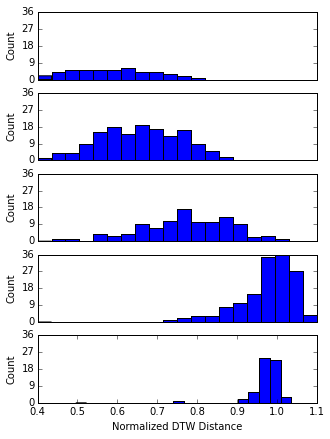

In [9]:
# Plot a histogram for each rating
plt.figure(figsize=(5, 7))
# Keep track of the largest bin in all histograms
max_count = 0
# Compute the range of scores
hist_range = (min(r[2] for r in ratings), max(r[2] for r in ratings))
# Plot 5 histograms
for n in [5, 4, 3, 2, 1]:
    plt.subplot(5, 1, 6 - n)
    # Plot a histogram for this rating
    counts, _, _ = plt.hist(
        [r[2] for r in ratings if r[1] == n], 20, hist_range)
    # Update the max count seen over all histograms
    max_count = max_count if max(counts) < max_count else int(max(counts))
    # Force the x limits
    plt.xlim(hist_range)
    # Keep track of the ticks to set later
    ticks = plt.xticks()[0]
    plt.ylabel('Count')
    plt.xticks([])
# Force the Y limits to the largest count range
for n in [1, 2, 3, 4, 5]:
    plt.subplot(5, 1, n)
    plt.ylim(0, max_count)
    plt.yticks(range(0, max_count + 1, max_count/4))
# Set ticks of the final subplot to the tick range
plt.xticks(ticks)
plt.xlabel('Normalized DTW Distance')